# 从零开始训练模型

In [199]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pickle
from tqdm import tqdm
import os
import sys

n_train = 12500
path = 'D:\\PythonWorkSpace\\MLND\\P6_Dogs_VS_Cats\\train\\'
height = 128
width = 128

## 思路

1.图像预处理

    - 图像尺寸归一化（或补黑边）
    - 图像尺寸压缩以减小数据量
    - 取值归一化    
    - 将训练数据Pickle为单个对象
   
   
2.建立模型

    - 从最简单的CNN模型入手，从0开始训练模型，看训练效果，不要幻想一次搞定。    
    - 从预训练模型入手，进行迁移学习，对比自己训练模型看训练效果。


3.增加功能：图像识别框

    - FastRCNN    
    - YOLO v2
    

## 1. 数据预处理

- 由于图片的尺寸相当随机，为方便给神经网络训练，需要先统一所有训练图片的尺寸。


- 由于绝大多数图片的尺寸在 `500 x 500` 左右，如果用 `cv2.imread` 进行JPG解压缩并全部读入内存，总体积会从500M膨胀至17G，数据量较大。相比CIFAR10 `32 x 32` 的超迷你图片来说，会导致神经网络训练耗时长的多，因此应该对图片统一进行尺寸压缩。


- 首先尝试将尺寸压缩至 `64 x 64`

In [200]:
img_db = np.zeros((25000, height, width, 3), dtype=np.uint8)

for i in tqdm(range(n_train)):
    img = cv2.imread(path + 'cat\\' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (height, width))   
    img_db[i] = img
    
for i in tqdm(range(n_train)):
    img = cv2.imread(path + 'dog\\' + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img = cv2.resize(img, (height, width))   
    img_db[i + n_train] = img

100%|███████████████████████████████████████████████████| 12500/12500 [00:26<00:00, 465.95it/s]


In [201]:
img_db.shape

(25000, 128, 128, 3)

In [202]:
img_db.size

1228800000

In [203]:
str(sys.getsizeof(img_db)/1024/1024) + ' MB'

'1171.8751373291016 MB'

In [204]:
from keras.utils import to_categorical
zeros = np.zeros(12500, dtype=np.uint8)    # cat = 0
ones = np.ones(12500, dtype=np.uint8)      # dog = 1
labels = np.concatenate((zeros, ones))
# labels = to_categorical(labels)
obj = {'img_db': img_db, 'img_labels': labels}
with open('training_set.p', 'wb') as file:
    pickle.dump(obj, file)

### 导入预处理后的训练数据，方便随时开始训练

In [205]:
with open('training_set_128.p', 'rb') as f:
    training_set = pickle.load(f)

img_db = training_set['img_db']
img_labels = training_set['img_labels']
img_db.shape

(25000, 128, 128, 3)

### 将训练集数据顺序随机化

In [206]:
img_index = np.arange(25000)
np.random.shuffle(img_index)
img_db_shuffled = np.zeros((25000, height, width, 3), dtype=np.uint8)
img_labels_shuffled = np.zeros((25000,), dtype=np.uint8)
j = 0
for i in img_index:
    img_db_shuffled[j] = img_db[i]
    img_labels_shuffled[j] = img_labels[i]
    j += 1

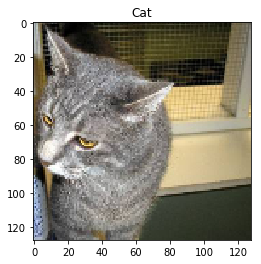

In [216]:
# 检验一下打散图片和标签的关系是否正确
img_id = np.random.choice(range(25000))
plt.imshow(img_db_shuffled[img_id], cmap='gray')
label = 'Cat'
if img_labels_shuffled[img_id] == 1:
    label = 'Dog'
plt.title(label)
plt.show()

### 划分训练集和验证集

In [220]:
x_test, y_test = img_db[:2500], img_labels[:2500]
x_train, y_train = img_db[2500:], img_labels[2500:]
print(x_test.shape)
print(x_train.shape)

(2500, 128, 128, 3)
(22500, 128, 128, 3)


## 2. 模型训练

In [213]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Convolution2D, MaxPool2D, MaxPooling2D, Flatten, Dropout
from keras.layers.normalization import BatchNormalization

# CCM -> CCM -> CCM -> CCM -> Flatten -> Dropout -> FC -> output
def create_model(num_CCM, num_kernel):
    # Input Layers
    input_tensor = Input((height, width, 3))
    x = input_tensor

    # Convolution + Pooling Layer (4层CCM级联，模拟VGG16的结构)
    # 32C 32C M -> 64C 64C M -> 128C 128C M -> 256C 256C M
    for i in range(num_CCM):
        conv_num_output = num_kernel * (2**i)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters=conv_num_output, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D(pool_size=2, strides=2, padding='valid')(x)
    
    # Flatten
    x = Flatten()(x)
    
    # Dropout
    x = Dropout(0.25)(x)
    
    # Fully-Connected Layer
    x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

    model = Model(inputs=input_tensor, outputs=x, name='dogVScat')
    return model

In [291]:
# 1. Create Model (3 CCM)
model = create_model(3, 32)

# 2. Compile Model with metrics/optimizer/loss
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [292]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_33 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_34 (Batc (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 60, 60, 64)        18496     
__________

In [ ]:
model.fit(x=x_train, y=y_train, batch_size=128, epochs=20)

## 使用验证集评估模型准确率

In [284]:
y_pred = model.predict(x_test)
y_result = []
for i in y_pred:
    if i[0] > 0.5:
        y_result.append(1)
    else:
        y_result.append(0)
y_result = np.array(y_result, dtype=np.uint8)

In [285]:
result = (y_result == y_test)
np.count_nonzero(result)/2500

0.8868

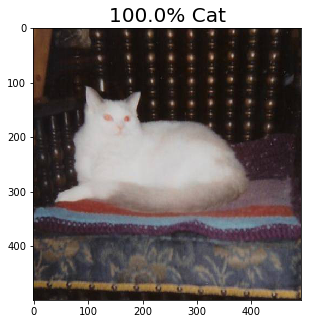

In [280]:
test_path = 'D:\\PythonWorkSpace\\MLND\\P6_Dogs_VS_Cats\\test\\'
random_img = np.random.choice(range(12500))
img = cv2.imread(test_path + str(random_img) + '.jpg')
img = img[:, :, ::-1]
img_resize = cv2.resize(img, (128, 128))
x = img_resize[None, :]
y_pred = model.predict(x)
y_pred = y_pred[0][0]
result = ''
prob = ''
if (y_pred >= 0.5):
    result = 'Dog'
    prob = np.round(y_pred * 100, 2)
else:
    result = 'Cat'
    prob = 100 - np.round(y_pred * 100, 2)
    
plt.figure(figsize=(15, 5))
plt.imshow(img, cmap='gray')
plt.title(str(prob) + '% ' + result, size=20)
plt.show()

## 输出预测结果

In [286]:
output = ['id,label',]
test_path = 'D:\\PythonWorkSpace\\MLND\\P6_Dogs_VS_Cats\\test\\'
for i in tqdm(range(1, 12501)):
    img = cv2.imread(test_path + str(i) + '.jpg')
    img = img[:, :, ::-1]
    img_resize = cv2.resize(img, (128, 128))
    x = img_resize[None, :]
    y_pred = model.predict(x)
    output.append(str(i) + ',' + str(y_pred[0][0]))

100%|███████████████████████████████████████████████████| 12500/12500 [01:02<00:00, 199.00it/s]


In [287]:
with open('test.csv', 'w') as f:
    for line in output:
        f.writelines(line + '\n')